### PROJECT OBJECTIVE
The project aims to develop a Diabetes Mellitus Prediction Model that will predict the likelihood of an individual developing diabetes based on key health indicators such as age, blood pressure, body mass index (BMI), glucose levels, and other medical features. Leveraging machine learning algorithms, this model will serve as a reliable tool for early detection of diabetes, enabling timely intervention and management. The model is trained on labeled datasets and employs performance metrics like accuracy and recall to ensure robust predictions.

### DATA DICTIONARY

- **Id:** Unique identifier for each data entry
- **Pregnancies:** Number of times the patient has been pregnant
- **Glucose:** Plasma glucose concentration over 2 hours in an oral glucose tolerance test
- **BloodPressure:** Diastolic blood pressure (mm Hg)
- **SkinThickness:** Triceps skinfold thickness (mm)
- **Insulin:** 2-Hour serum insulin (mu U/ml)
- **BMI:** Body mass index (weight in kg / height in m^2)
- **DiabetesPedigreeFunction:** Diabetes pedigree function, a genetic score of diabetes
- **Age:** Age in years
- **Outcome:** Binary classification indicating the presence (1) or absence (0) of diabetes

### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import pickle
import streamlit as st

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
data = pd.read_csv('diabetes.csv')
data.head()

Id  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0   1            6      148             72             35        0  33.6   
1   2            1       85             66             29        0  26.6   
2   3            8      183             64              0        0  23.3   
3   4            1       89             66             23       94  28.1   
4   5            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

### DATA OVERVIEW/INSPECTION

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        2768 non-null   int64  
 1   Pregnancies               2768 non-null   int64  
 2   Glucose                   2768 non-null   int64  
 3   BloodPressure             2768 non-null   int64  
 4   SkinThickness             2768 non-null   int64  
 5   Insulin                   2768 non-null   int64  
 6   BMI                       2768 non-null   float64
 7   DiabetesPedigreeFunction  2768 non-null   float64
 8   Age                       2768 non-null   int64  
 9   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 216.4 KB


In [4]:
#Data Stastistics
data.describe().T

count         mean         std     min      25%  \
Id                        2768.0  1384.500000  799.197097   1.000  692.750   
Pregnancies               2768.0     3.742775    3.323801   0.000    1.000   
Glucose                   2768.0   121.102601   32.036508   0.000   99.000   
BloodPressure             2768.0    69.134393   19.231438   0.000   62.000   
SkinThickness             2768.0    20.824422   16.059596   0.000    0.000   
Insulin                   2768.0    80.127890  112.301933   0.000    0.000   
BMI                       2768.0    32.137392    8.076127   0.000   27.300   
DiabetesPedigreeFunction  2768.0     0.471193    0.325669   0.078    0.244   
Age                       2768.0    33.132225   11.777230  21.000   24.000   
Outcome                   2768.0     0.343931    0.475104   0.000    0.000   

                               50%       75%      max  
Id                        1384.500  2076.250  2768.00  
Pregnancies                  3.000     6.000    17.00  
Glucose                    117.000   141.000   199.00  
BloodPressure               72.000    80.000   122.00  
SkinThickness               23.000    32.000   110.00  
Insulin                     37.000   130.000   846.00  
BMI                         32.200    36.625    80.60  
DiabetesPedigreeFunction     0.375     0.624     2.42  
Age                         29.000    40.000    81.00  
Outcome                      0.000     1.000     1.00

##### Observations

- The maximum pregnancies is 17.0, this is higher than expected and could be a data entry error or outlier.
- The minimum BMI is 0.0, which is significantly below the plausible range. This suggests a potential data entry error.
- The maximum BMI is 80, which exceeds the plausible upper limit, indicating the presence of an outlier or possibly data entry error.
- The minimum Glucose level is 0.0, which is also extremely lower than expected, especially for test done 2hours after oral glucose, suggesting 
  an inaccurate measurement or data entry error.
- The minimum value of 0.0  for both Insulin and Skin Thickness is also below the plausible range for these indices and may be considered as data entry error.

In [5]:
# Check for Missing values
data.isnull().sum()

Id                          0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

##### No missing value

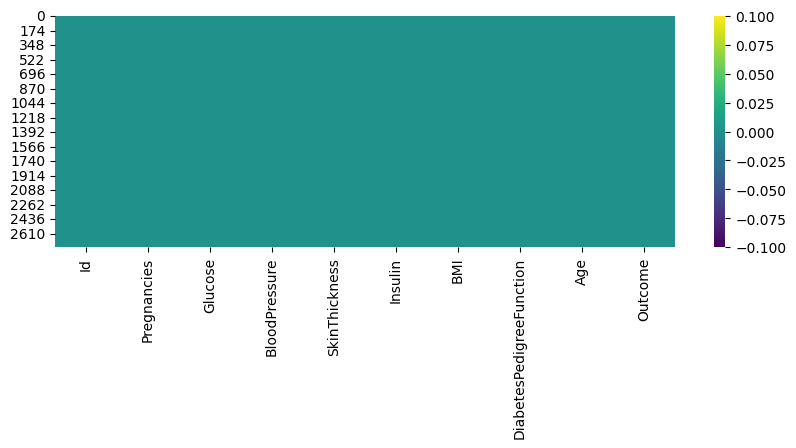

In [6]:
plt.figure(figsize=(10,3))
sns.heatmap(data.isnull(), cbar=True, cmap='viridis');

In [7]:
data.duplicated().sum()

np.int64(0)

##### No duplicates

In [8]:
data.head(3)

Id  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0   1            6      148             72             35        0  33.6   
1   2            1       85             66             29        0  26.6   
2   3            8      183             64              0        0  23.3   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1

### EXPLORATORY DATA ANALYSIS (EDA)

##### UNIVARIATE

In [9]:
data['Outcome'].value_counts()

Outcome
0    1816
1     952
Name: count, dtype: int64

<Axes: xlabel='Outcome', ylabel='Count'>

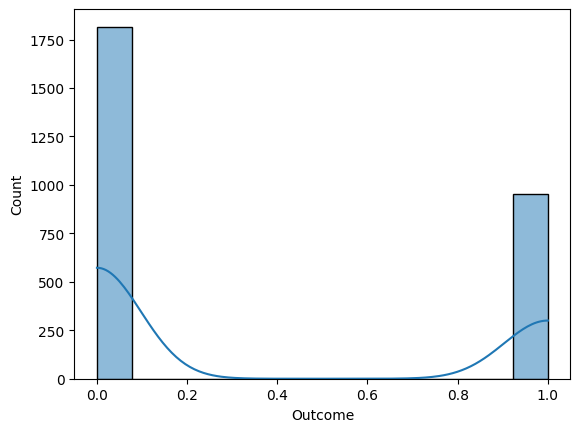

In [10]:
sns.histplot(data=data, x='Outcome', kde=True)

From the above histogram, most of the patients (about 1800) in the dataset did not have diabetes making the dataset imbalance.

Outcome
0    1816
1     952
Name: count, dtype: int64


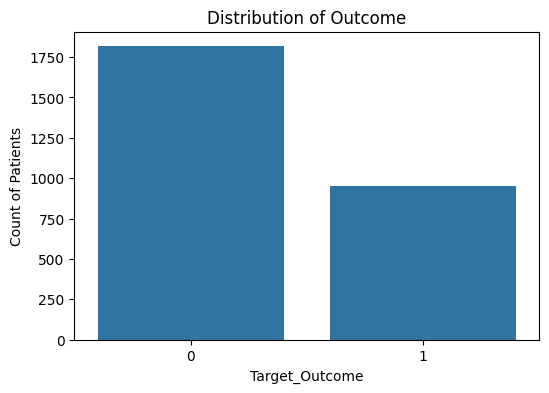

In [11]:
def label(Tg):
    if Tg == 1:
        return 'Yes'
    else:
        return 'No'
data['Target_Outcome'] = data['Outcome'].apply(label)
plt.figure(figsize=(6,4))
sns.countplot(x='Outcome', data=data)
plt.xlabel('Target_Outcome')
plt.ylabel('Count of Patients')
plt.title('Distribution of Outcome')
print(data['Outcome'].value_counts())

As observed from the histogram, the count plot showed most of the patients in the dataset did not have diabetes.

Target_Outcome
No     65.61
Yes    34.39
Name: count, dtype: float64


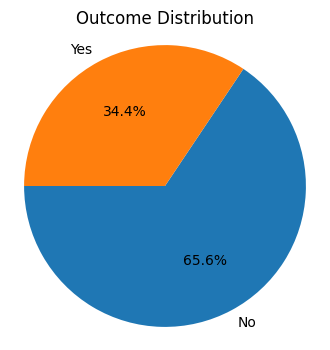

In [12]:
Outcome = round(data['Target_Outcome'].value_counts()/data.shape[0]*100,2)
print(Outcome)

# Plot pie chart for ratings distribution
plt.figure(figsize=(4,4))
plt.pie(Outcome, labels=Outcome.index, autopct='%1.1f%%', startangle=180)
plt.title('Outcome Distribution')
plt.axis('equal')
plt.show()

Just above 1/3 (34.4%) have diabetes while 65.6% did not.

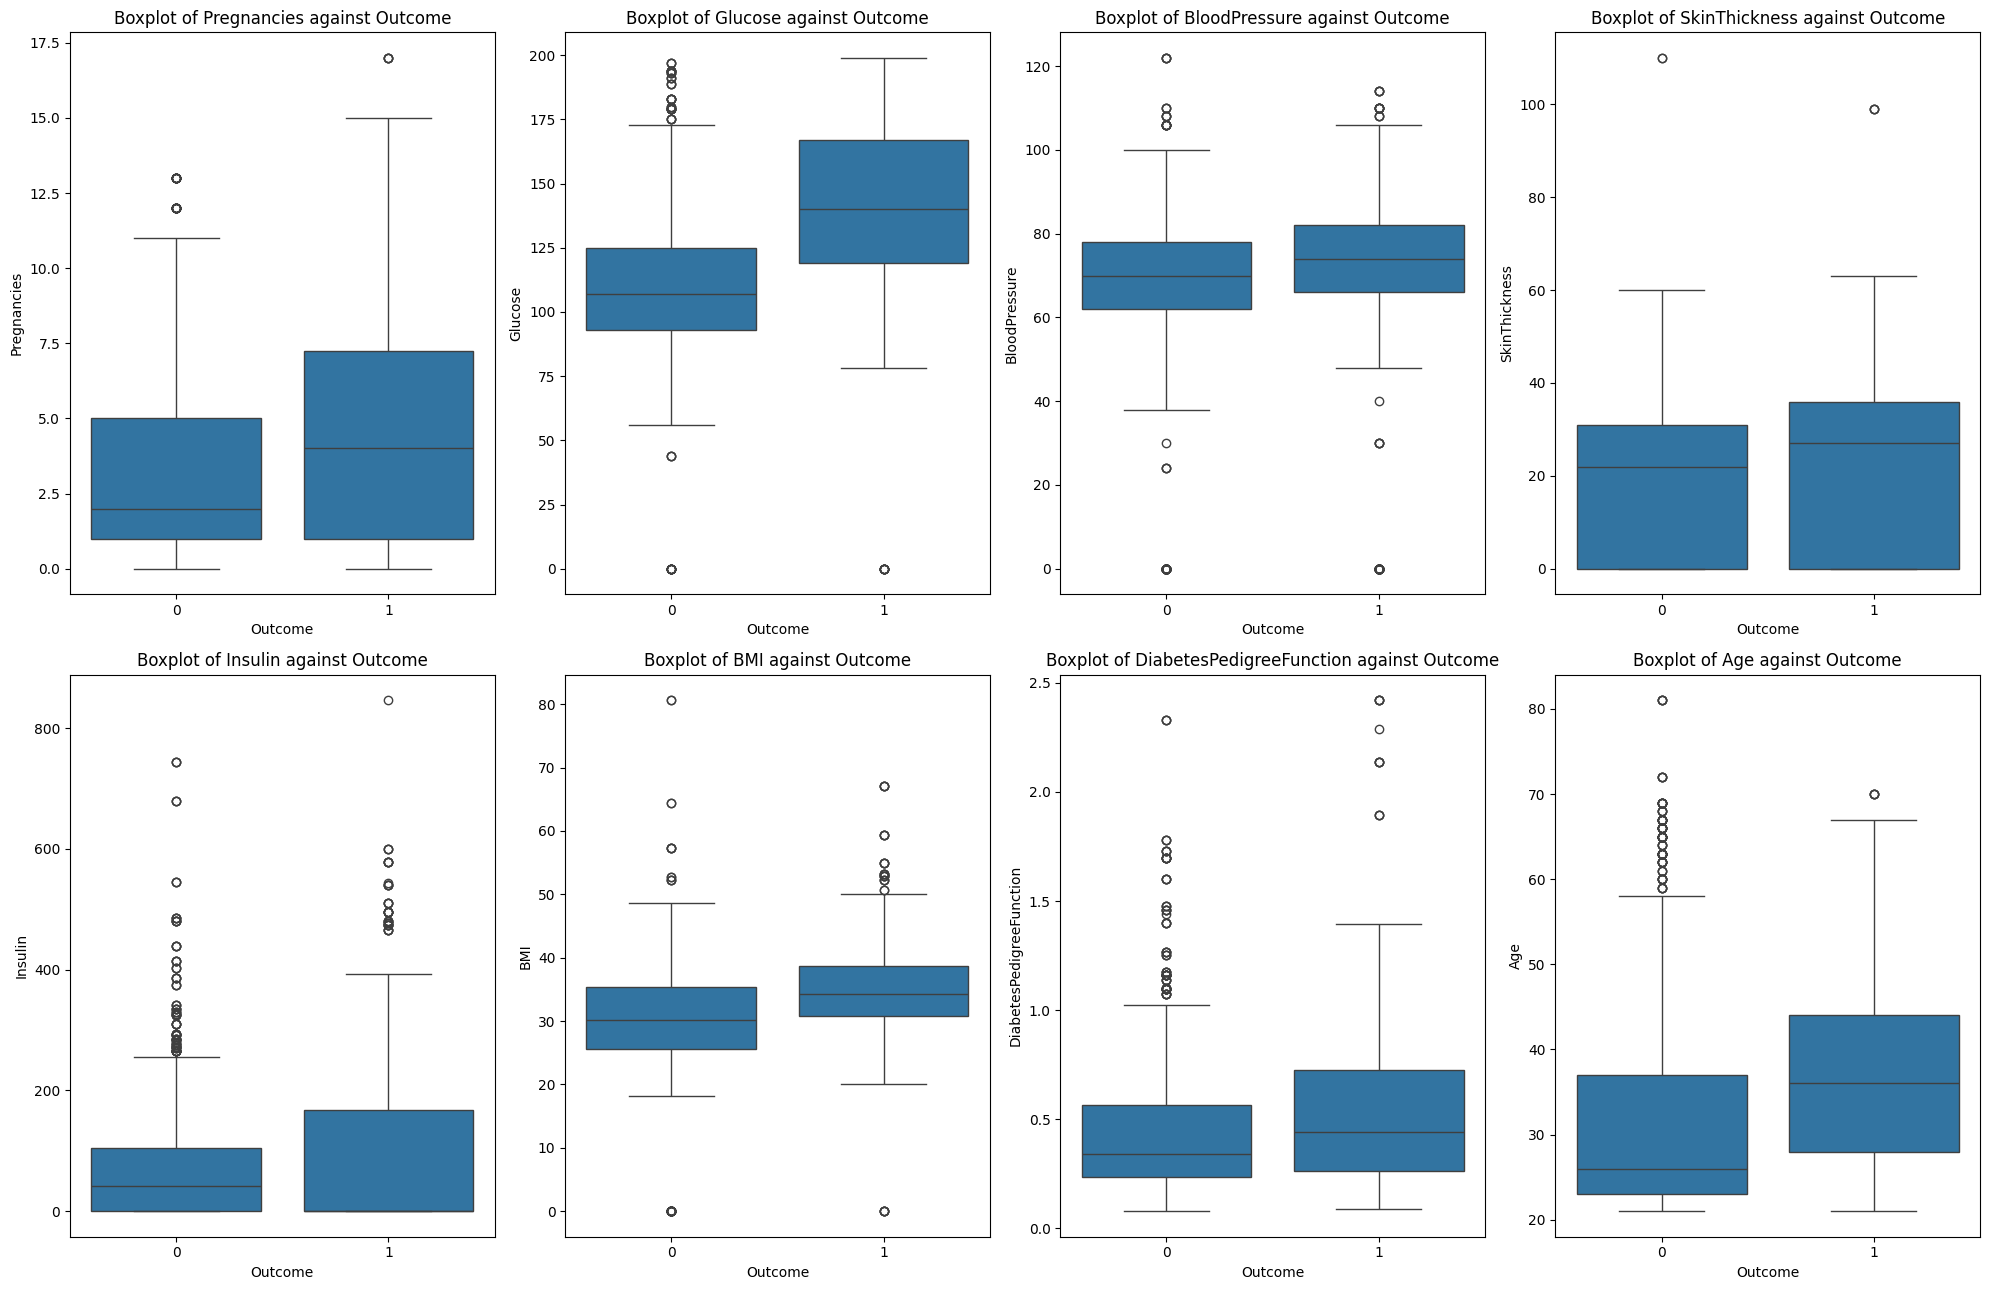

In [13]:
# Create subplots with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 13))

# List of features to plot
selected_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Plot each feature in a separate subplot
for i, feature in enumerate(selected_features):
    row = i // 4  # Determine the row
    col = i % 4   # Determine the column
    sns.boxplot(x='Outcome', y=feature, data=data, ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot of {feature} against Outcome')

# Adjust layout
plt.tight_layout()
plt.show()

##### OBSERVATIONS
- **Pregnancies vs Outcome -** The median for Outcome 1 (diabetes) is higher than the Outcome 0 (no diabetes). So there is a potential association between an increased number of pregnacies 
    and likelihood of having diabetes. Outliers are present in both outcomes.

- **Glucose vs Outcome -** The median glucose level for Outcome 1 is notably higher than for Outcome 0. Individuals with median glucose level of around 110 and below are likely to be non 
   diabetic while those with median glucose level higher than 140 are likely to be diabetic. There are both upper and lower outliers.

- **BloodPressure vs Outcome -** The boxplots show that the median blood pressure for diabetic patients is slightly higher than nondiabetic patients. Both outcomes have outliers, but they 
   are more pronounced for outcome 1.

- **SkinThickness vs Outcome -** It can be observed from the boxplots, the median skin thickness is slightly higher for diabetic patients than nondiabetic patients. Therefore, skin thickness 
   can be an indicator of diabetes.

- **Insulin vs Outcome -** There is a notable difference in the insulin levels between the two outcomes, with outcome 1 showing a higher median and more variability. Those with Outcome 1 (diabetes) 
   have a broader range of insulin levels, with a higher median compared to those with Outcome 0. This suggests that elevated insulin levels or greater variability in insulin levels might be linked 
   to an increased risk of diabetes.

- **BMI vs Outcome -** The median BMI is slightly higher for outcome 1 compared to outcome 0.

- **DiabetesPedigreeFunction (DPF)-** DPF measures the probability of diabetes based on diabetes family history and patient's age. The boxplots show the Outcome 1 has higher median value 
   compare to Output 0. Therefor, patients with lower DPF are much less likely to have diabetes while the patients with higher DPF are much more likely to have diabetes.

- **Age vs Outcome -** The median age for outcome 1 is higher than for outcome 0, suggesting that older individuals are more associated with outcome 1. Also, Outcome 1 has a wider spread of ages, 
   while outcome 0 is more concentrated around the lower age ranges.

In [14]:
data['Age'].min()

np.int64(21)

In [15]:
data['Age'].max()

np.int64(81)

Text(0.5, 1.0, 'Age Group Distribution')

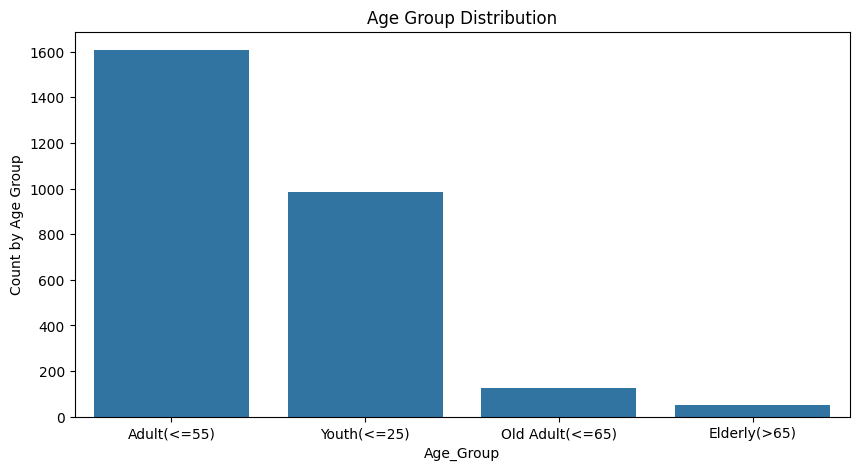

In [16]:
def Age_Group(Age):
    if Age <= 25:
        return 'Youth(<=25)'
    elif Age <= 55:
        return 'Adult(<=55)'
    elif Age <= 65:
        return 'Old Adult(<=65)'
    else:
        return 'Elderly(>65)'
data['Age_Group'] = data['Age'].apply(Age_Group)

# Patients Age Group Visualization
plt.figure(figsize=(10,5))
sns.countplot(x='Age_Group', data=data)
plt.xlabel('Age_Group')
plt.ylabel('Count by Age Group')
plt.title('Age Group Distribution')

High proportion of the patients in the dataset were of the age 55 and below

Text(0.5, 1.0, 'No of Pregnancies by Age_Group')

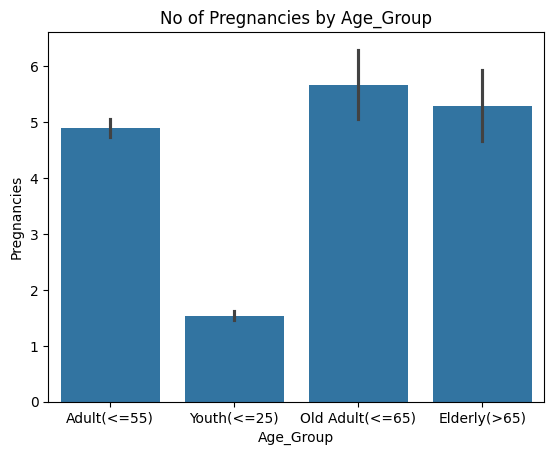

In [17]:
sns.barplot(x='Age_Group', y='Pregnancies', data=data)
plt.title('No of Pregnancies by Age_Group')

No of Pregnancies was around 5 for the Age_Group Adult(<=55), Old Adult(<=65) and Elderly(>65) while it is around 1 for the Youth(<=25)

Text(0.5, 1.0, 'Blood Pressure Distribution')

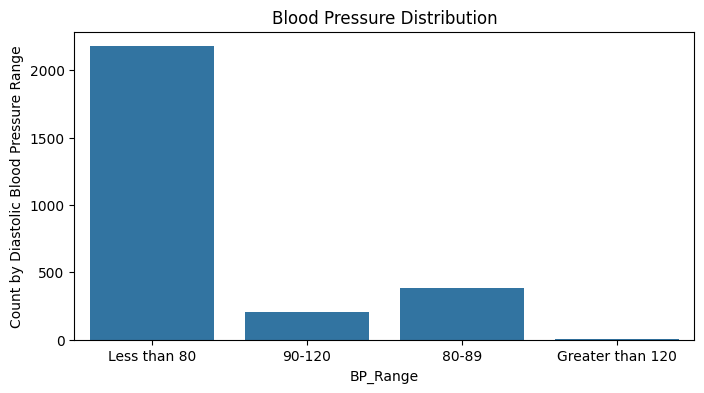

In [18]:
def BP_Range(BloodPressure):
    if BloodPressure <= 80:
        return 'Less than 80'
    elif 80 <= BloodPressure <= 89:
        return '80-89'
    elif 90 <= BloodPressure <= 120:
        return '90-120'
    else:
        return 'Greater than 120'

data['BP_Range'] = data['BloodPressure'].apply(BP_Range)

# Patients Age Group Visualization
plt.figure(figsize=(8,4))
sns.countplot(x='BP_Range', data=data)
plt.xlabel('BP_Range')
plt.ylabel('Count by Diastolic Blood Pressure Range')
plt.title('Blood Pressure Distribution')

Majority have blood pressure of less than 80

In [19]:
data.head(3)

Id  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0   1            6      148             72             35        0  33.6   
1   2            1       85             66             29        0  26.6   
2   3            8      183             64              0        0  23.3   

   DiabetesPedigreeFunction  Age  Outcome Target_Outcome    Age_Group  \
0                     0.627   50        1            Yes  Adult(<=55)   
1                     0.351   31        0             No  Adult(<=55)   
2                     0.672   32        1            Yes  Adult(<=55)   

       BP_Range  
0  Less than 80  
1  Less than 80  
2  Less than 80

<Axes: xlabel='BMI', ylabel='Count'>

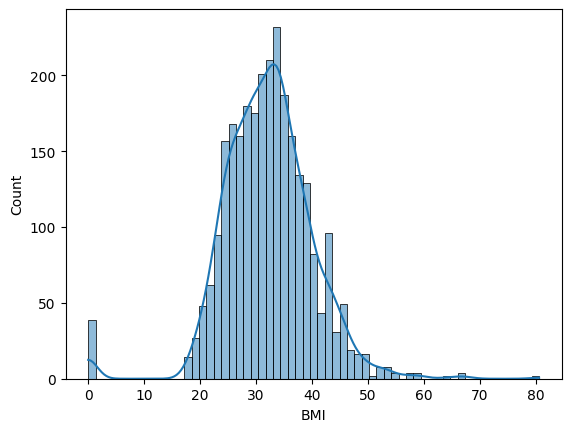

In [20]:
sns.histplot(data=data, x='BMI', kde=True)

- Unimodal distribution with peak 30.
- The chart skewed to the right.
- The value range from 0 80 most of the data between 20 and 40.

<Axes: xlabel='SkinThickness', ylabel='Count'>

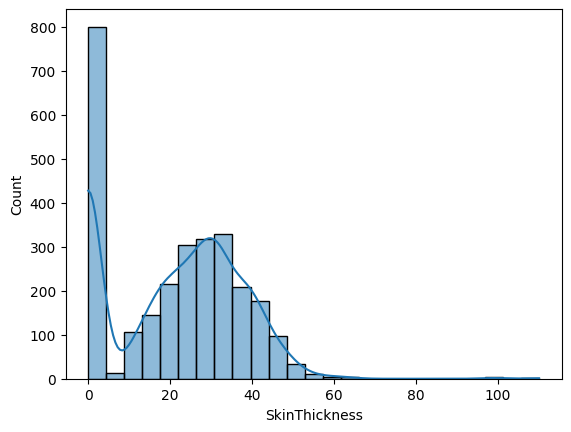

In [21]:
sns.histplot(data=data, x='SkinThickness', kde=True)

- Bimodal distribution, peaked at 0 and around 30.
- Right-skewed.
- Most data clustered between 20 and 40.

<Axes: xlabel='Glucose', ylabel='Count'>

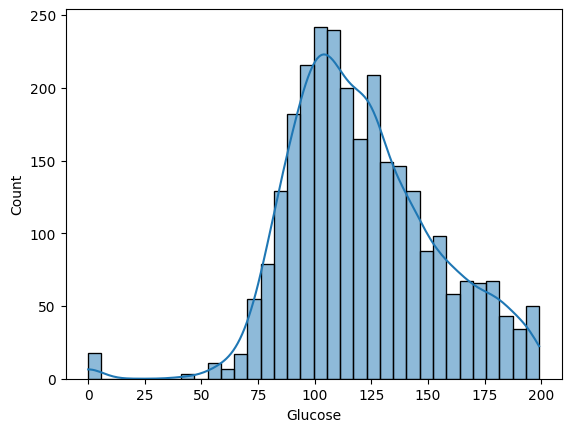

In [22]:
sns.histplot(data=data, x='Glucose', kde=True)

- The chart has unimodal distribution with a peak around 100.
- The chart is right-skewed.
- The range is between 0 and 200 with most data points between 70 150.

<Axes: xlabel='Insulin', ylabel='Count'>

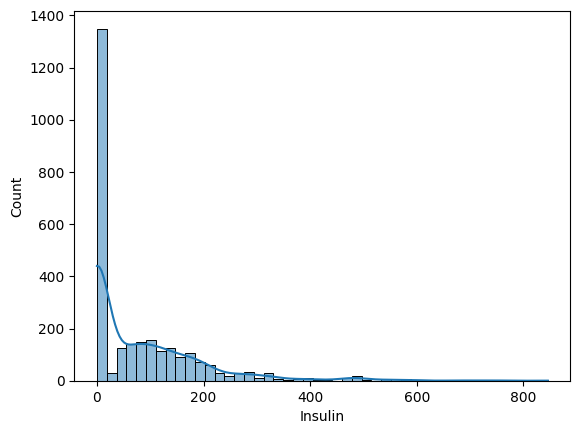

In [23]:
sns.histplot(data=data, x='Insulin', kde=True)

- Right-skewed distribution with most of the value concentrated around 0, indicating either most patiests have low insulin or data entry error or missinf values.
- There are outliers with some above 600.

##### BIVARIATE ANALYSIS

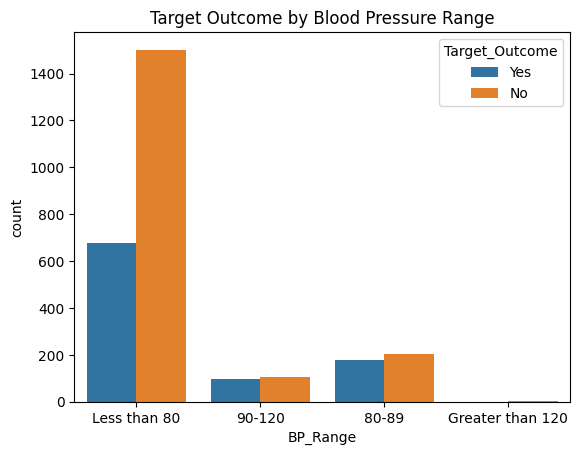

In [24]:
sns.countplot(x='BP_Range', hue='Target_Outcome', data=data)
plt.title('Target Outcome by Blood Pressure Range');

Across all the BP_Range, most patients did not have diabetes

##### MULTIVARIATE ANALYSIS

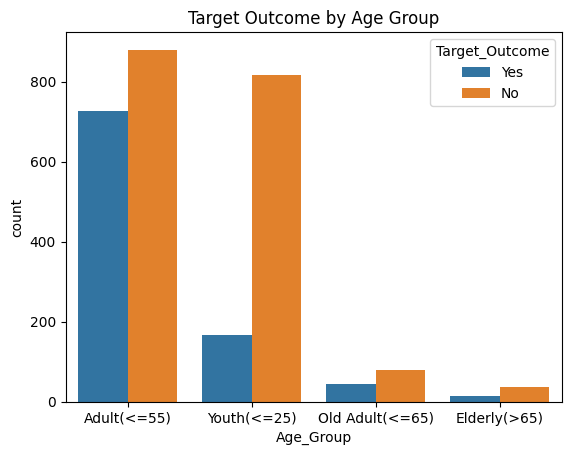

In [25]:
sns.countplot(x='Age_Group', hue='Target_Outcome', data=data)
plt.title('Target Outcome by Age Group');

Across all age groups, most patients did not have diabetes

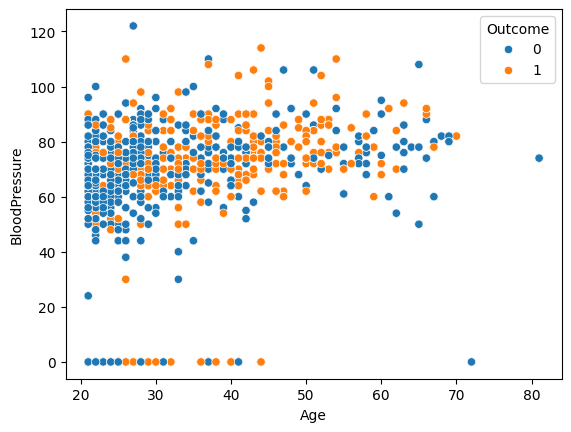

In [26]:
sns.scatterplot(x=data["Age"], y = data["BloodPressure"], hue = data["Outcome"]);

- Diabetic patients were spread across different age ranges and blood group with clustering between ages 30-60 and blood pressure around 60-90.
- Non-diabetic patients have cluster around age group 20-30 and blood pressure around 50 and 90.


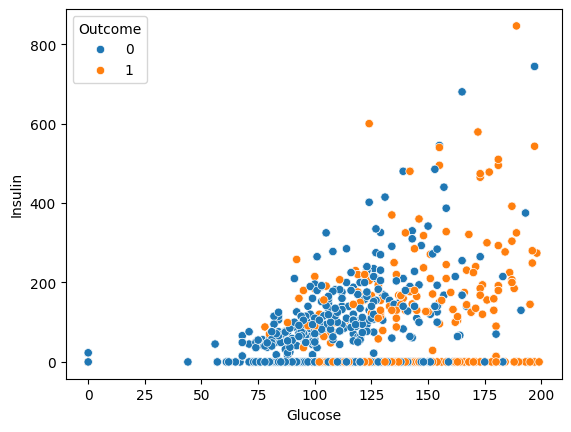

In [27]:
sns.scatterplot(x=data["Glucose"], y=data["Insulin"], hue=data["Outcome"]);

- Non-diabetic patients have a concentration between glucose values of 75-150 and insulin values of
  0-250.
- Diabetic patients clustered around glucose level above 125 and insulin value around 100 and 300.


<Axes: xlabel='BMI', ylabel='Age'>

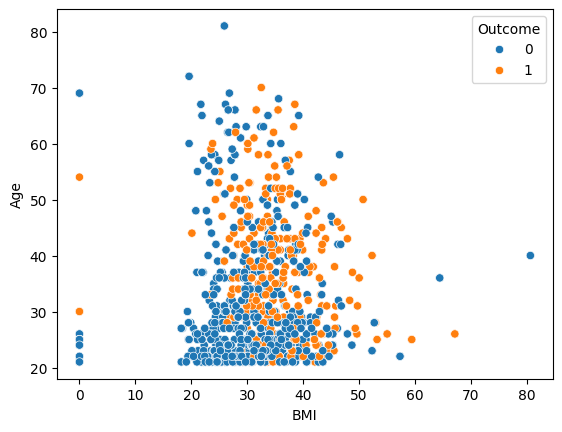

In [28]:
sns.scatterplot(x=data["BMI"], y=data["Age"], hue=data["Outcome"])

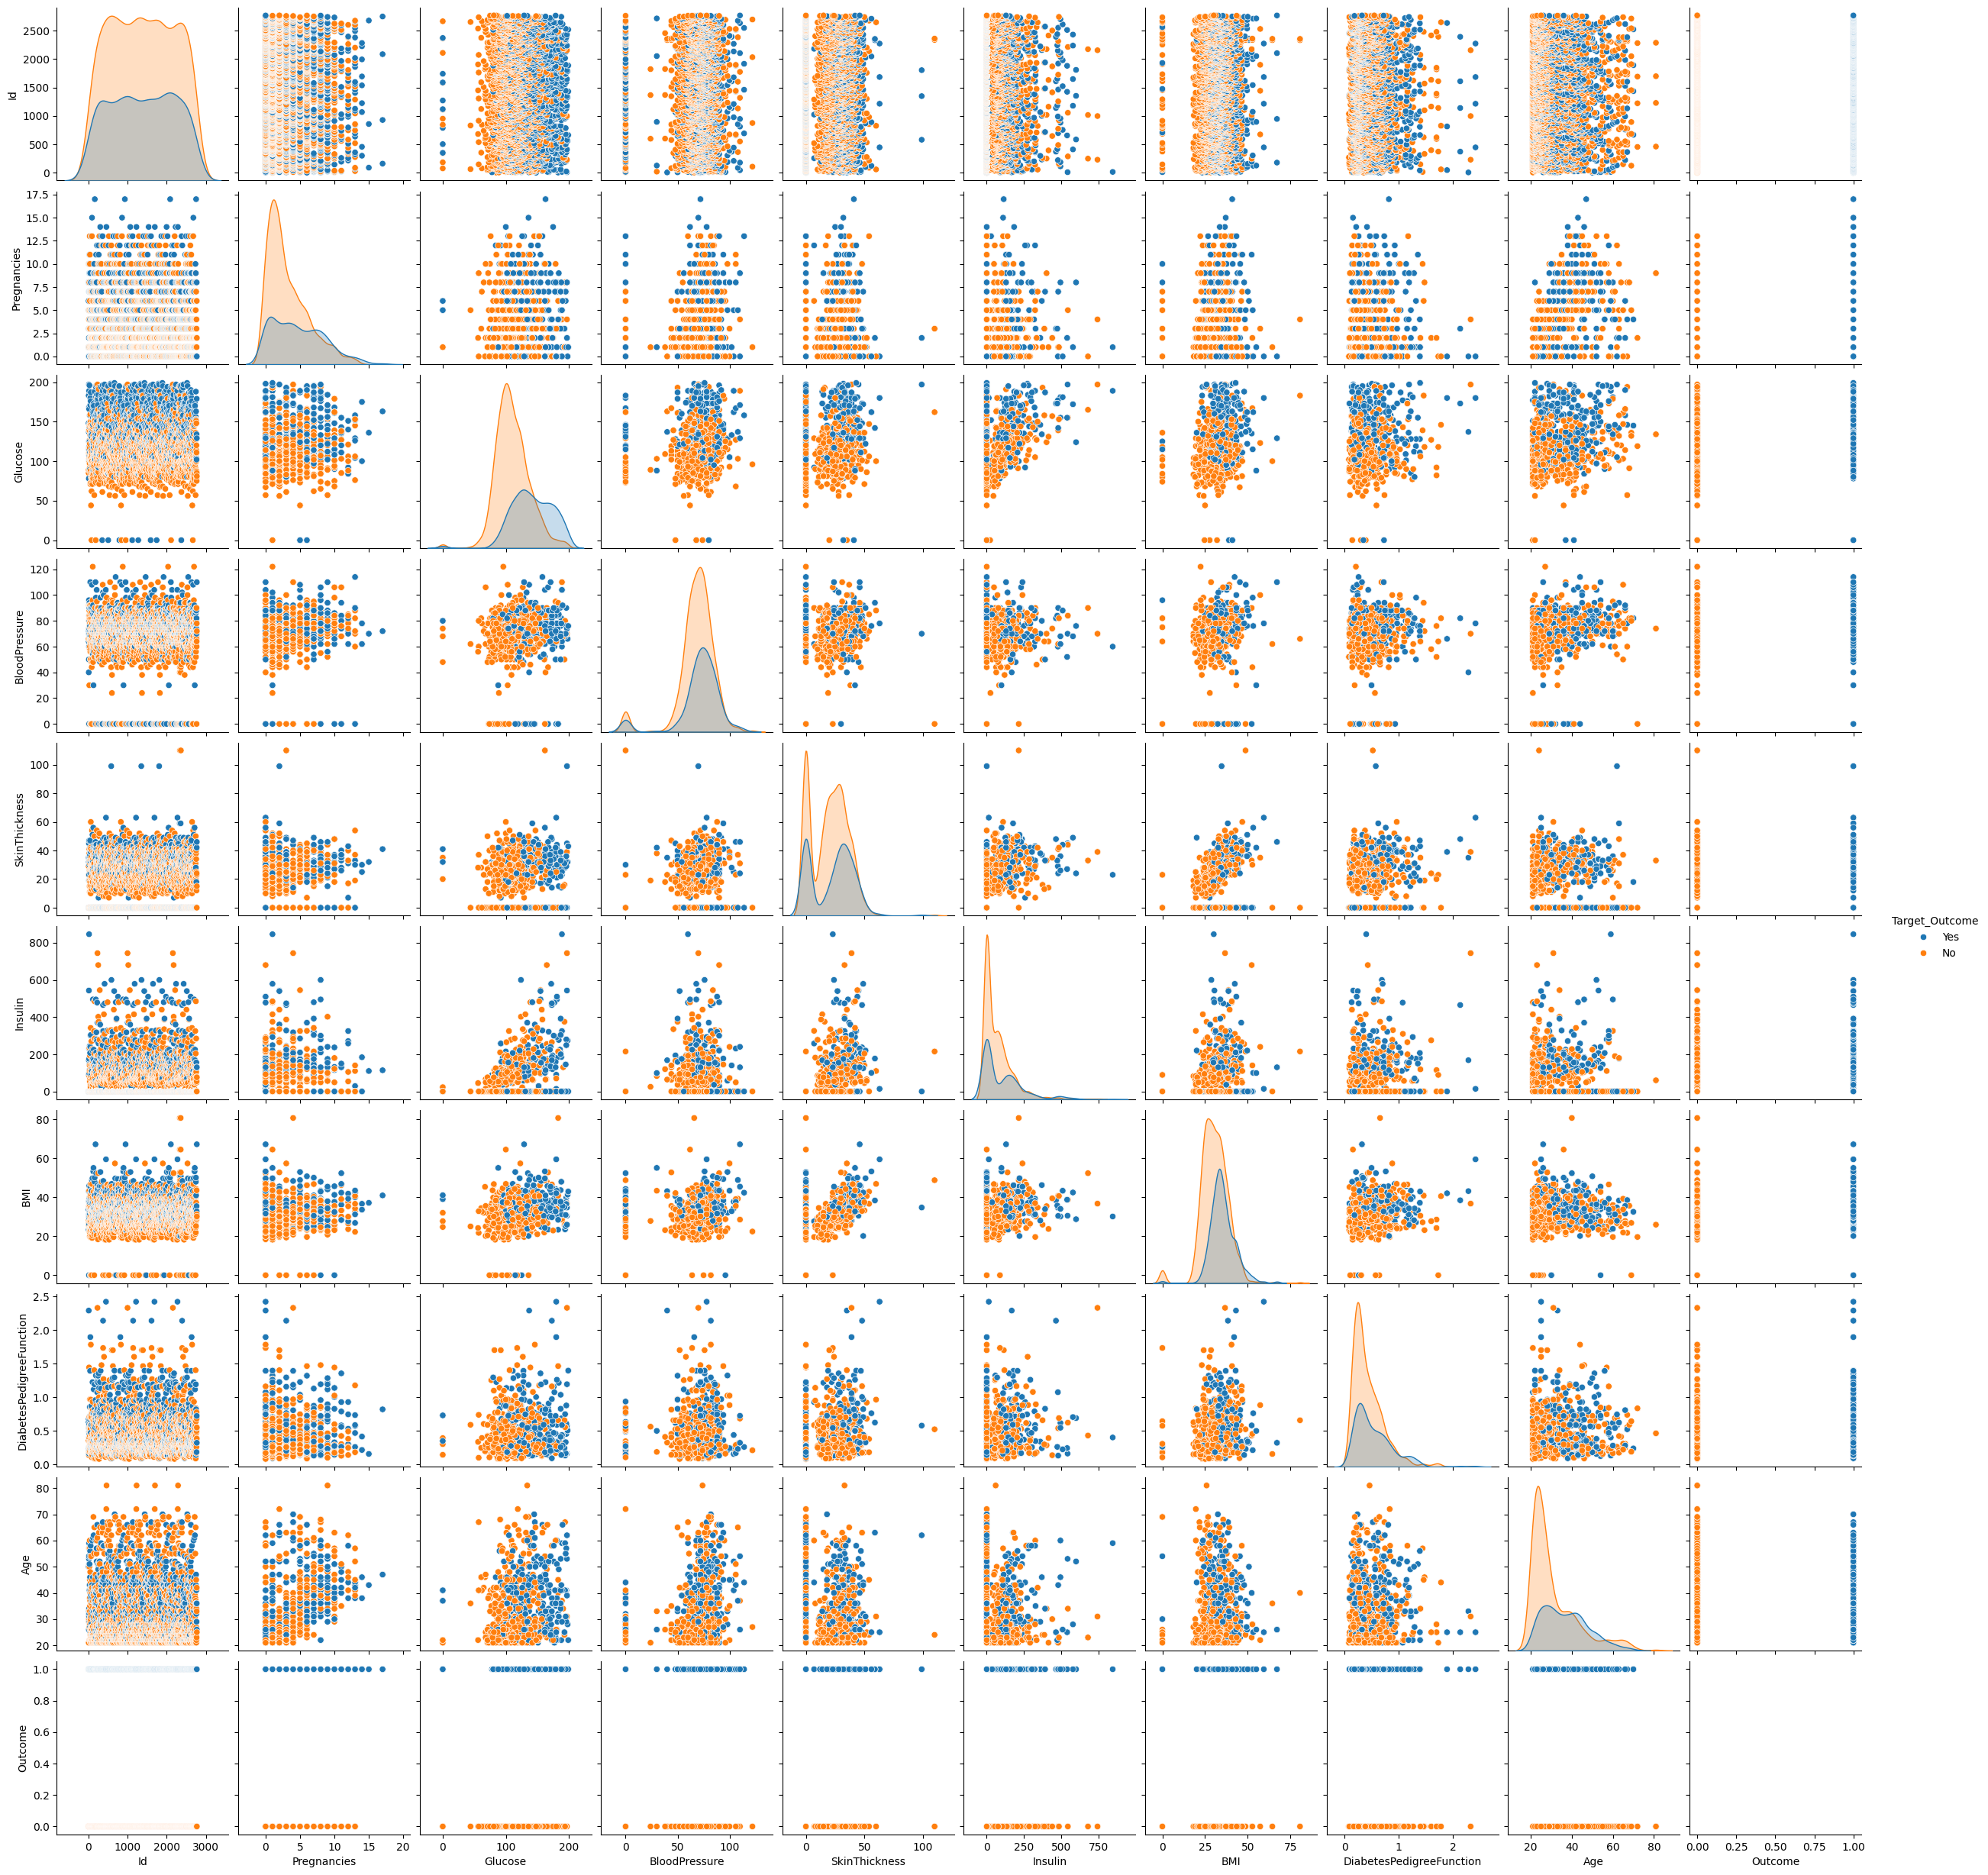

In [29]:
sns.pairplot(data, hue=('Target_Outcome'))

In [30]:
data.head(2)

Id  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0   1            6      148             72             35        0  33.6   
1   2            1       85             66             29        0  26.6   

   DiabetesPedigreeFunction  Age  Outcome Target_Outcome    Age_Group  \
0                     0.627   50        1            Yes  Adult(<=55)   
1                     0.351   31        0             No  Adult(<=55)   

       BP_Range  
0  Less than 80  
1  Less than 80

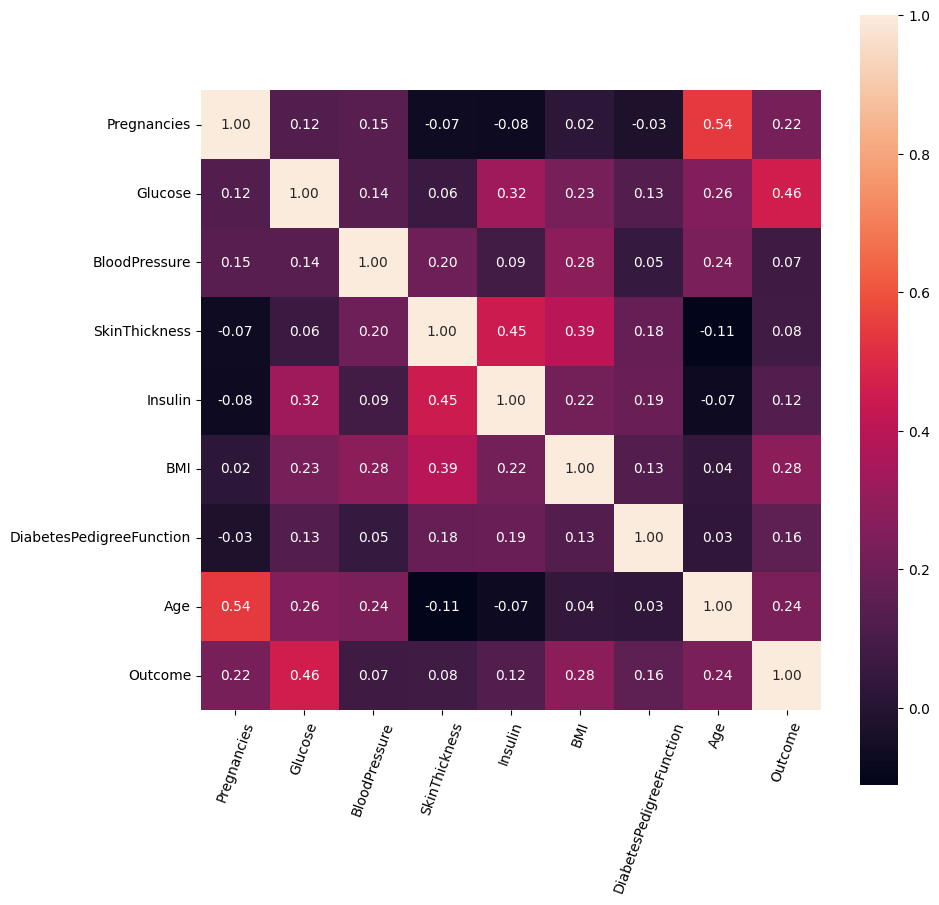

In [31]:
data = data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']]
plt.figure(figsize=(10,10))
hm = sns.heatmap(data.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10})
plt.xticks(rotation=70)
plt.show()

In [32]:
#Drop the target variable
Label = data.pop('Outcome')

In [33]:
Label.head(5)

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

### HANDLING OF OUTLIERS (NORMALISE NUMERICAL FEATURES)

In [34]:
scaler = MinMaxScaler()

num_var = data.select_dtypes(include=["int64", "float64"])

scaled_data = pd.DataFrame(scaler.fit_transform(num_var), columns=data.columns)

with open('numd_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [35]:
scaled_data.head(5)

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.352941  0.743719       0.590164       0.318182  0.000000  0.416873   
1     0.058824  0.427136       0.540984       0.263636  0.000000  0.330025   
2     0.470588  0.919598       0.524590       0.000000  0.000000  0.289082   
3     0.058824  0.447236       0.540984       0.209091  0.111111  0.348635   
4     0.000000  0.688442       0.327869       0.318182  0.198582  0.534739   

   DiabetesPedigreeFunction       Age  
0                  0.234415  0.483333  
1                  0.116567  0.166667  
2                  0.253629  0.183333  
3                  0.038002  0.000000  
4                  0.943638  0.200000

### MODEL BUILDING AND EVALUATION

In [36]:
# Split dataset to trainig and evalustion subsets
x_train, x_test, y_train, y_test = train_test_split(scaled_data, Label, test_size=0.25, random_state=360)

In [37]:
bc_mod = BaggingClassifier()

In [38]:
bc_mod.fit(x_train, y_train)

BaggingClassifier()

In [39]:
bc_pred = bc_mod.predict(x_test)

In [40]:
print('Bagging Classifier')
print('Accuracy:', accuracy_score(y_test, bc_pred))
print('Precision:', precision_score(y_test, bc_pred))
print('Recall:', recall_score(y_test, bc_pred))
print('F1-score:', f1_score(y_test, bc_pred))

Bagging Classifier
Accuracy: 0.9855491329479769
Precision: 1.0
Recall: 0.9607843137254902
F1-score: 0.98


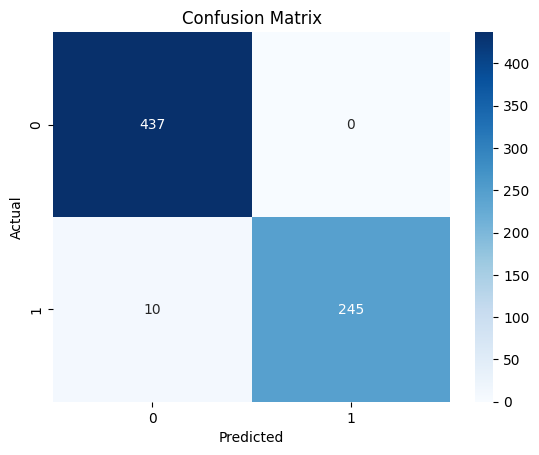

In [41]:
# Create a Confusion Matrix
bcm = confusion_matrix(y_test, bc_pred)

# Visualize the confusion matrix
sns.heatmap(bcm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [42]:
lr_mod = LogisticRegression()

In [43]:
lr_mod.fit(x_train, y_train)

LogisticRegression()

In [44]:
lr_pred = lr_mod.predict(x_test)

In [45]:
print('Logistic Regression')
print('Accuracy:', accuracy_score(y_test, lr_pred))
print('Precision:', precision_score(y_test, lr_pred))
print('Recall:', recall_score(y_test, lr_pred))
print('F1-score:', f1_score(y_test, lr_pred))

Logistic Regression
Accuracy: 0.7630057803468208
Precision: 0.7898089171974523
Recall: 0.48627450980392156
F1-score: 0.6019417475728155


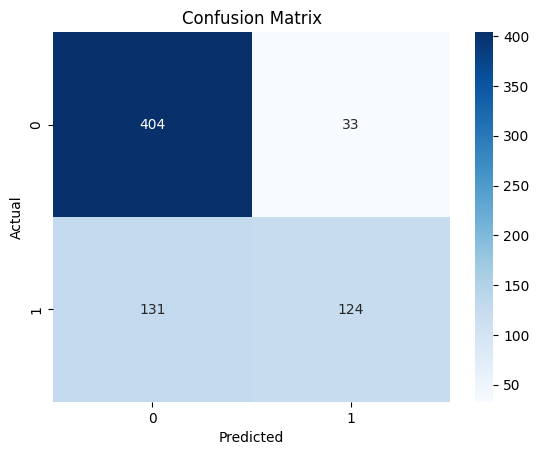

In [46]:
# Create a Confusion Matrix
lcm = confusion_matrix(y_test, lr_pred)

# Visualize the confusion matrix
sns.heatmap(lcm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [47]:
svc_mod = SVC()

In [48]:
svc_mod.fit(x_train, y_train)

SVC()

In [49]:
svc_pred = svc_mod.predict(x_test)

In [50]:
print('SVC Classifier')
print('Accuracy:', accuracy_score(y_test, svc_pred))
print('Precision:', precision_score(y_test, svc_pred))
print('Recall:', recall_score(y_test, svc_pred))
print('F1-score:', f1_score(y_test, svc_pred))

SVC Classifier
Accuracy: 0.791907514450867
Precision: 0.8245614035087719
Recall: 0.5529411764705883
F1-score: 0.6619718309859155


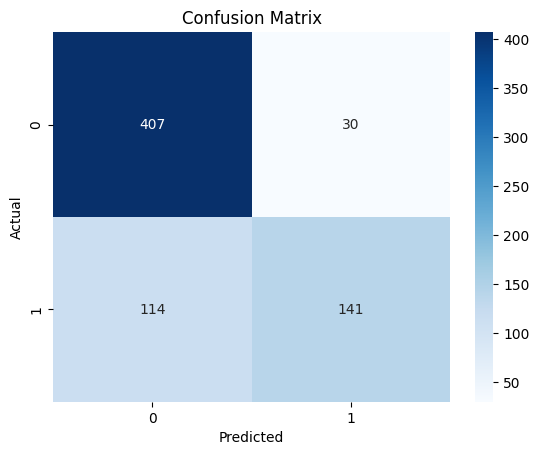

In [51]:
# Create a Confusion Matrix
scm = confusion_matrix(y_test, svc_pred)

# Visualize the confusion matrix
sns.heatmap(scm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [52]:
dt_mod = DecisionTreeClassifier()

In [53]:
dt_mod.fit(x_train, y_train)

DecisionTreeClassifier()

In [54]:
dt_pred = dt_mod.predict(x_test)

In [55]:
print('Decision Tree Classifier')
print('Accuracy:', accuracy_score(y_test, dt_pred))
print('Precision:', precision_score(y_test, dt_pred))
print('Recall:', recall_score(y_test, dt_pred))
print('F1-score:', f1_score(y_test, dt_pred))

Decision Tree Classifier
Accuracy: 0.9971098265895953
Precision: 1.0
Recall: 0.9921568627450981
F1-score: 0.9960629921259843


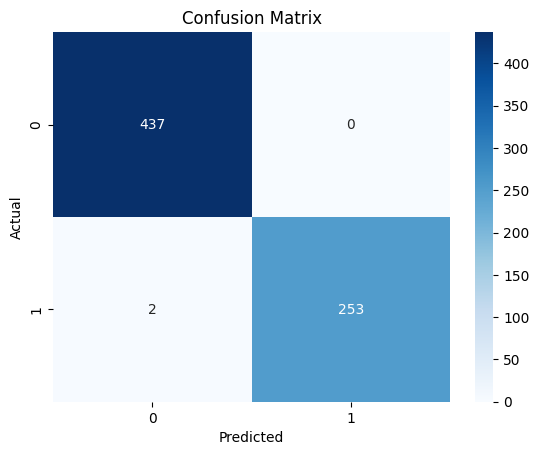

In [56]:
# Create a Confusion Matrix
dcm = confusion_matrix(y_test, dt_pred)

# Visualize the confusion matrix
sns.heatmap(dcm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [57]:
rf_mod = RandomForestClassifier()

In [58]:
rf_mod.fit(x_train, y_train)

RandomForestClassifier()

In [59]:
rf_pred = rf_mod.predict(x_test)

In [60]:
print('Random Forest Classifier')
print('Accuracy:', accuracy_score(y_test, rf_pred))
print('Precision:', precision_score(y_test, rf_pred))
print('Recall:', recall_score(y_test, rf_pred))
print('F1-score:', f1_score(y_test, rf_pred))

Random Forest Classifier
Accuracy: 0.9956647398843931
Precision: 1.0
Recall: 0.9882352941176471
F1-score: 0.9940828402366864


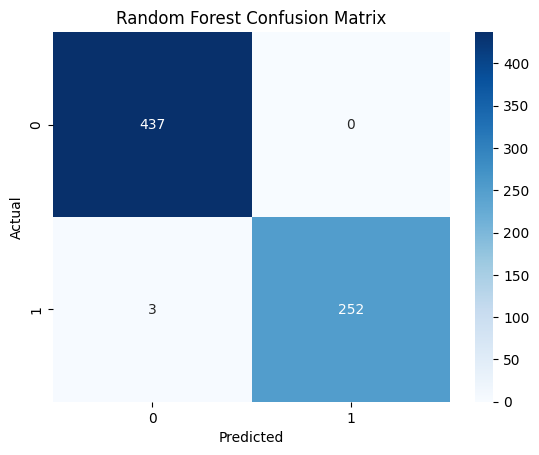

In [61]:
# Create a Confusion Matrix
rcm = confusion_matrix(y_test, rf_pred)

# Visualize the confusion matrix
sns.heatmap(rcm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [62]:
xgb_mod = XGBClassifier()

In [63]:
xgb_mod.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [64]:
xgb_pred = xgb_mod.predict(x_test)

In [65]:
print('XGB Classifier')
print('Accuracy:', accuracy_score(y_test, xgb_pred))
print('Precision:', precision_score(y_test, xgb_pred))
print('Recall:', recall_score(y_test, xgb_pred))
print('F1-score:', f1_score(y_test, xgb_pred))

XGB Classifier
Accuracy: 0.9971098265895953
Precision: 1.0
Recall: 0.9921568627450981
F1-score: 0.9960629921259843


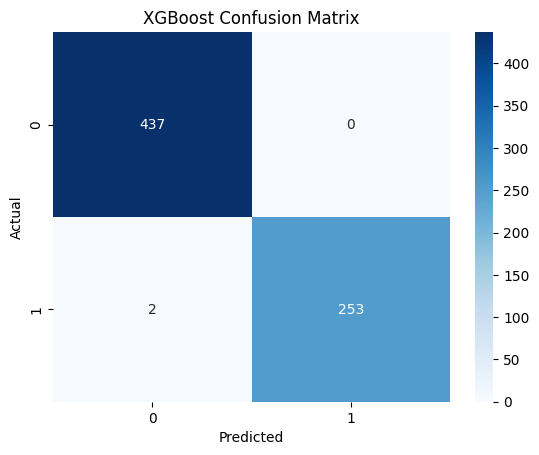

In [66]:
# Create a Confusion Matrix
xcm = confusion_matrix(y_test, xgb_pred)

# Visualize the confusion matrix
sns.heatmap(xcm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

### HANDLE DATA IMBALANCE AND OVERFITTING

In [67]:
x=scaled_data
y=Label

In [68]:
# Define your models
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('XGBoost', XGBClassifier(eval_metric='mlogloss')),
    ('Support Vector Machine', SVC(probability=True)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Bagging', BaggingClassifier())
]

In [69]:
# Initialize SMOTE
smote = SMOTE()

# Initialize cross-validation
cv = StratifiedKFold(n_splits=5)

In [70]:
# Dictionary to store results
results = {}

In [71]:
# Iterate over each model
for name, model in models:
    # Create a pipeline with SMOTE and the model
    pipeline = Pipeline([('smote', smote), ('model', model)])
    
    # List to store performance metrics for each fold
    fold_accuracies = []
    
    # Perform cross-validation
    for train_index, val_index in cv.split(x, y):
        x_train_cv, x_val_cv = x.iloc[train_index], x.iloc[val_index]
        y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]
        
        # Fit the model
        pipeline.fit(x_train_cv, y_train_cv)
        
        # Predict and evaluate the model
        y_pred = pipeline.predict(x_val_cv)
        accuracy = accuracy_score(y_val_cv, y_pred)
        fold_accuracies.append(accuracy)
        
        # Print detailed classification report
        print(f"{name} - Classification report for this fold:\n{classification_report(y_val_cv, y_pred)}")
    
    # Store mean accuracy for the model
    results[name] = {
        'mean_accuracy': sum(fold_accuracies) / len(fold_accuracies),
        'fold_accuracies': fold_accuracies
    }

Logistic Regression - Classification report for this fold:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       363
           1       0.61      0.72      0.66       191

    accuracy                           0.74       554
   macro avg       0.72      0.74      0.73       554
weighted avg       0.76      0.74      0.75       554

Logistic Regression - Classification report for this fold:
              precision    recall  f1-score   support

           0       0.85      0.76      0.81       363
           1       0.63      0.75      0.68       191

    accuracy                           0.76       554
   macro avg       0.74      0.76      0.75       554
weighted avg       0.78      0.76      0.76       554

Logistic Regression - Classification report for this fold:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       364
           1       0.66      0.73      0.69       190

    a

In [72]:
# Print overall results for all models
for name, metrics in results.items():
    print(f"{name} - Mean Accuracy: {metrics['mean_accuracy']}")
    print(f"{name} - Fold Accuracies: {metrics['fold_accuracies']}")

Logistic Regression - Mean Accuracy: 0.7583081452660578
Logistic Regression - Fold Accuracies: [0.7418772563176895, 0.759927797833935, 0.776173285198556, 0.7613019891500904, 0.7522603978300181]
Random Forest - Mean Accuracy: 0.9920486222181601
Random Forest - Fold Accuracies: [0.9873646209386282, 0.9981949458483754, 1.0, 1.0, 0.9746835443037974]
XGBoost - Mean Accuracy: 0.99277064387881
XGBoost - Fold Accuracies: [0.9891696750902527, 1.0, 1.0, 1.0, 0.9746835443037974]
Support Vector Machine - Mean Accuracy: 0.7915439904426789
Support Vector Machine - Fold Accuracies: [0.779783393501805, 0.7978339350180506, 0.8032490974729242, 0.7920433996383364, 0.7848101265822784]
Decision Tree - Mean Accuracy: 0.9891592299306049
Decision Tree - Fold Accuracies: [0.9747292418772563, 1.0, 1.0, 1.0, 0.9710669077757685]
Bagging - Mean Accuracy: 0.9924109386934411
Bagging - Fold Accuracies: [0.9855595667870036, 1.0, 0.9981949458483754, 1.0, 0.9783001808318263]


### SAVE BEST PERFORMING MODEL

In [73]:
with open('xgb_mod.pkl', 'wb') as file:
    pickle.dump(xgb_mod, file)

In [74]:
with open("numd_scaler.pkl", "rb") as file:
    scaler = pickle.load(file)

with open("xgb_mod.pkl", "rb") as file:
    model = pickle.load(file)

def transform_data(data):
    num_var = data.select_dtypes(include = ["int64", "float64"])

    # Scale numerical entries
    scaled_data = pd.DataFrame(scaler.fit_transform(num_var), columns=data.columns)

    return scaled_data

### FEATURE IMPORTANCE

In [75]:
from xgboost import plot_importance

booster = xgb_mod.get_booster()

In [76]:
# Get importance scores for features based on gain
importance_dict = booster.get_score(importance_type='gain')

# Print the importance scores
for feature, score in importance_dict.items():
    print('**Feature Importance using Gain Metric**:')
    print(f"Feature: {feature}, Score: {score}")

**Feature Importance using Gain Metric**:
Feature: Pregnancies, Score: 1.5274680852890015
**Feature Importance using Gain Metric**:
Feature: Glucose, Score: 4.361052513122559
**Feature Importance using Gain Metric**:
Feature: BloodPressure, Score: 1.3153220415115356
**Feature Importance using Gain Metric**:
Feature: SkinThickness, Score: 1.7292567491531372
**Feature Importance using Gain Metric**:
Feature: Insulin, Score: 2.282599925994873
**Feature Importance using Gain Metric**:
Feature: BMI, Score: 2.639955520629883
**Feature Importance using Gain Metric**:
Feature: DiabetesPedigreeFunction, Score: 1.843259572982788
**Feature Importance using Gain Metric**:
Feature: Age, Score: 2.6064281463623047


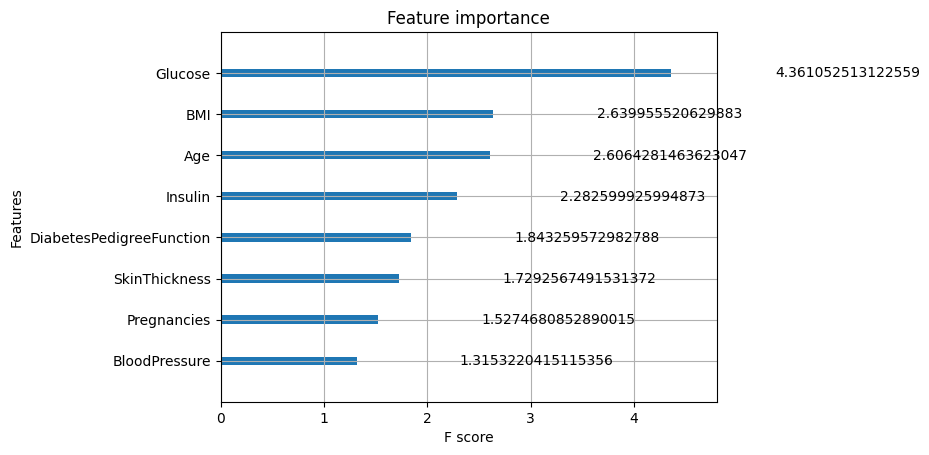

In [77]:
plot_importance(booster, importance_type='gain') 
plt.show()

##### Feature Importance (XGBoost Model)
The feature importance for the XGBoost model was determined using the **"gain" metric**, which reflects how much each feature improves the performance of splits in the decision trees.

The top 3 most important features were:

- **Glucose:** Showed the highest importance, making significant contributions in predicting the target variable.
- **BMI:** Ranked second in importance, indicating its strong influence on the predictions.
- **Age:** Also played an important role in predicting the outcome.
- **Insulin**, **DiabetesPedigreeFunction** and **SkinThickness**, contributed moderately to the model's performance, though they had lower importance compared to the top features.

- **Pregnancies** and **BloodPressure** though contributed to the model, there importances were lower than other key features.